In [1]:
import pandas as pd

df = pd.read_csv('data/smart_meters_london_2013.csv')

In [2]:
df.head()

,timestamp,0,1,2,3,4,5,6,7,8,...,4115,4116,4117,4118,4119,4120,4121,4122,4123,4124
0,2013-01-01 00:00:00,0.460,3.888,0.000,0.207,0.0,0.451,0.962,0.579,0.016,...,0.585,0.256,3.311,0.190,0.263,0.246,0.141,0.547,0.215,0.119
1,2013-01-01 01:00:00,0.426,2.603,0.158,0.106,0.0,0.375,1.121,1.340,0.107,...,0.493,0.192,1.695,0.222,0.231,0.221,0.131,0.474,0.227,0.103
2,2013-01-01 02:00:00,0.411,2.159,0.000,0.069,0.0,0.312,0.373,1.431,0.024,...,0.423,0.200,1.038,0.268,0.236,0.207,0.131,0.252,0.220,0.285
3,2013-01-01 03:00:00,0.395,2.040,0.170,0.065,0.0,0.199,0.421,0.413,0.010,...,0.182,0.262,0.586,0.119,0.188,0.220,0.104,0.091,0.202,0.097
4,2013-01-01 04:00:00,0.221,1.495,0.000,0.058,0.0,0.096,0.303,0.230,0.107,...,0.262,0.205,0.555,0.149,0.165,0.238,0.119,0.086,0.208,0.103


In [3]:
import matplotlib
import matplotlib.pyplot as plt

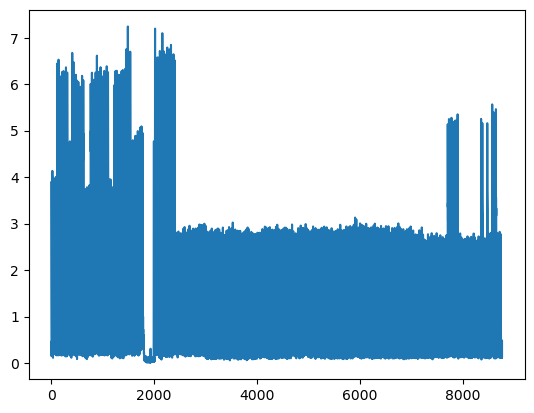

In [4]:
plt.plot(df["1"])

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns

2025-02-23 02:46:03.912948: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-23 02:46:03.913026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-23 02:46:03.913979: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 02:46:03.919094: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



Opt  L_rate Norm Momentum Decay Batch Size
Adam 0.001  Yes  Default  0.0   128

In [6]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')



Using GPU


In [8]:
results_path = Path('4rd_time_gan')
results_path.mkdir()

In [9]:
experiment = 0

In [10]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [11]:
### hdf_store = results_path / 'TimeSeriesGAN.h5'

In [12]:
#df.loc[1:2, 1:2]
df = df.iloc[:,1:]

In [13]:
df.shape

(8760, 4125)

In [14]:
seq_len = 24
n_seq = 4125
batch_size = 128

In [15]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

In [16]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

In [17]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

2025-02-23 02:47:06.903533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16138 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [18]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [19]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

In [20]:
hidden_dim = 24
num_layers = 3

In [21]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

In [22]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

In [23]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

In [24]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

In [25]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

In [26]:
train_steps = 1500
gamma = 1

mse = MeanSquaredError()
bce = BinaryCrossentropy()

In [27]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [28]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 4125)]        0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            306672    
                                                                 
 Recovery (Sequential)       (None, 24, 4125)          113925    
                                                                 
Total params: 420597 (1.60 MB)
Trainable params: 420597 (1.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


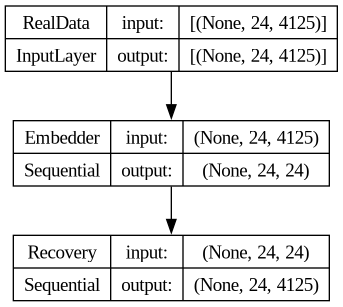

In [29]:
plot_model(autoencoder,
           to_file=(results_path / 'autoencoder.png').as_posix(),
           show_shapes=True)

In [30]:
autoencoder_optimizer = Adam()

In [31]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [32]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

  0%|          | 0/1500 [00:00<?, ?it/s]2025-02-23 02:48:32.640958: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-02-23 02:48:33.206650: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3d4c3b8210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-23 02:48:33.206688: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2025-02-23 02:48:33.211496: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740275313.316053 4183966 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 1500/1500 [00:32<00:00, 45.84it/s]


In [33]:
supervisor_optimizer = Adam()

In [34]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In [35]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 1500/1500 [00:24<00:00, 61.34it/s] 


###  Joint Training

##   Generator

In [36]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [37]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 4125)]        0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            306672    
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 325297 (1.24 MB)
Trainable params: 325297 (1.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


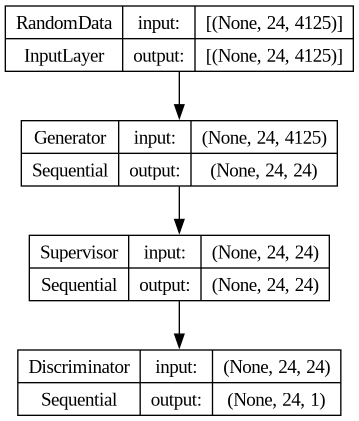

In [38]:
plot_model(adversarial_supervised, show_shapes=True)

In [39]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [40]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 4125)]        0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            306672    
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 317497 (1.21 MB)
Trainable params: 317497 (1.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


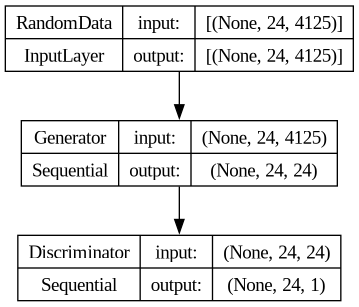

In [41]:
plot_model(adversarial_emb, show_shapes=True)

In [42]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [43]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 4125)]        0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            306672    
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Recovery (Sequential)       (None, 24, 4125)          113925    
                                                                 
Total params: 428397 (1.63 MB)
Trainable params: 428397 (1.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


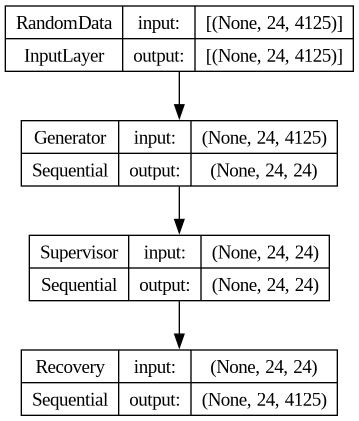

In [44]:
plot_model(synthetic_data, show_shapes=True)

In [45]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

##  Discriminator

In [46]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [47]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 4125)]        0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            306672    
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 317497 (1.21 MB)
Trainable params: 317497 (1.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


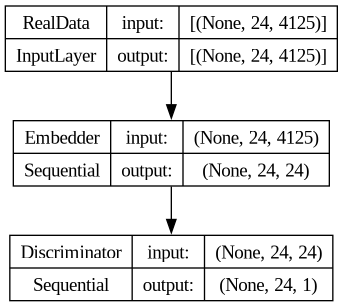

In [48]:
plot_model(discriminator_model, show_shapes=True)

In [49]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

##  Generator Train Step

In [50]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

### Embedding Train Step

In [51]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

###  Discriminator Train Step

In [52]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [53]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

###  Training Loop

In [54]:
import time
start = time.time()

step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
losses_d = []
losses_g = []
accuracies = []

for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 25 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    losses_g.append(step_g_loss_u)
    losses_d.append(step_d_loss)

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

end = time.time()
print(end - start)

     0 | d_loss: 2.0717 | g_loss_u: 0.7579 | g_loss_s: 0.0000 | g_loss_v: 0.1103 | e_loss_t0: 0.1102
    25 | d_loss: 1.8878 | g_loss_u: 0.9440 | g_loss_s: 0.0000 | g_loss_v: 0.1120 | e_loss_t0: 0.1111
    50 | d_loss: 2.0273 | g_loss_u: 1.1410 | g_loss_s: 0.0000 | g_loss_v: 0.1085 | e_loss_t0: 0.1085
    75 | d_loss: 1.9076 | g_loss_u: 1.0715 | g_loss_s: 0.0002 | g_loss_v: 0.1098 | e_loss_t0: 0.1097
   100 | d_loss: 1.9212 | g_loss_u: 1.1037 | g_loss_s: 0.0001 | g_loss_v: 0.1100 | e_loss_t0: 0.1099
   125 | d_loss: 1.9653 | g_loss_u: 1.1454 | g_loss_s: 0.0001 | g_loss_v: 0.1092 | e_loss_t0: 0.1082
   150 | d_loss: 1.8249 | g_loss_u: 1.0222 | g_loss_s: 0.0004 | g_loss_v: 0.1104 | e_loss_t0: 0.1094
   175 | d_loss: 1.8863 | g_loss_u: 1.0470 | g_loss_s: 0.0000 | g_loss_v: 0.1089 | e_loss_t0: 0.1077
   200 | d_loss: 1.8930 | g_loss_u: 1.0697 | g_loss_s: 0.0002 | g_loss_v: 0.1095 | e_loss_t0: 0.1079
   225 | d_loss: 1.9092 | g_loss_u: 1.0995 | g_loss_s: 0.0000 | g_loss_v: 0.1081 | e_loss_t

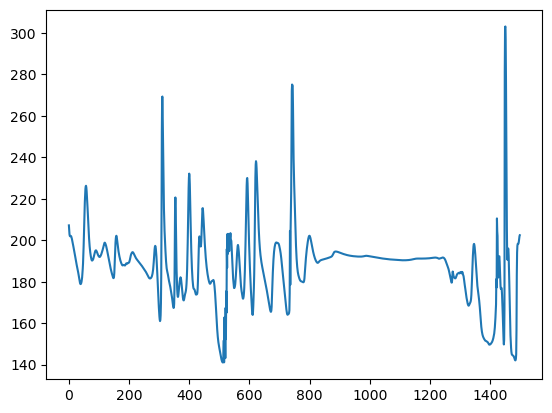

In [55]:
plt.plot(accuracies)

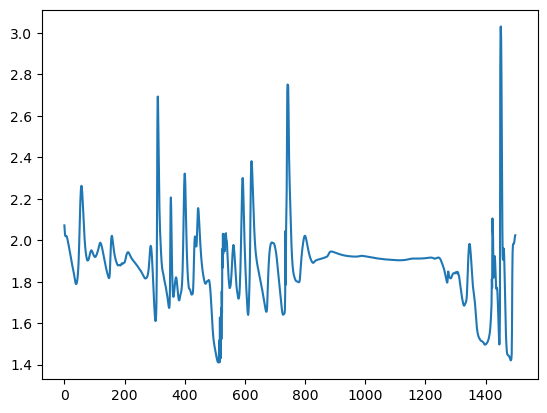

In [57]:
plt.plot(losses_d)


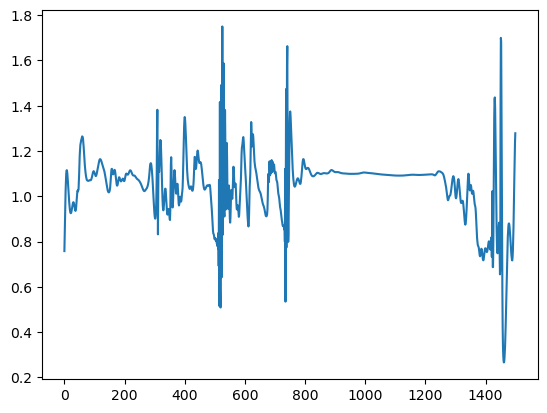

In [58]:
plt.plot(losses_g)

In [231]:
synthetic_data.save(log_dir / 'synthetic_data')

INFO:tensorflow:Assets written to: 2nd_time_gan/experiment_00/synthetic_data2/assets


INFO:tensorflow:Assets written to: 2nd_time_gan/experiment_00/synthetic_data2/assets


In [232]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [234]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(8704, 24, 4125)

In [235]:
np.save(log_dir / 'generated_data2.npy', generated_data)

In [236]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(8704, 24, 4125)

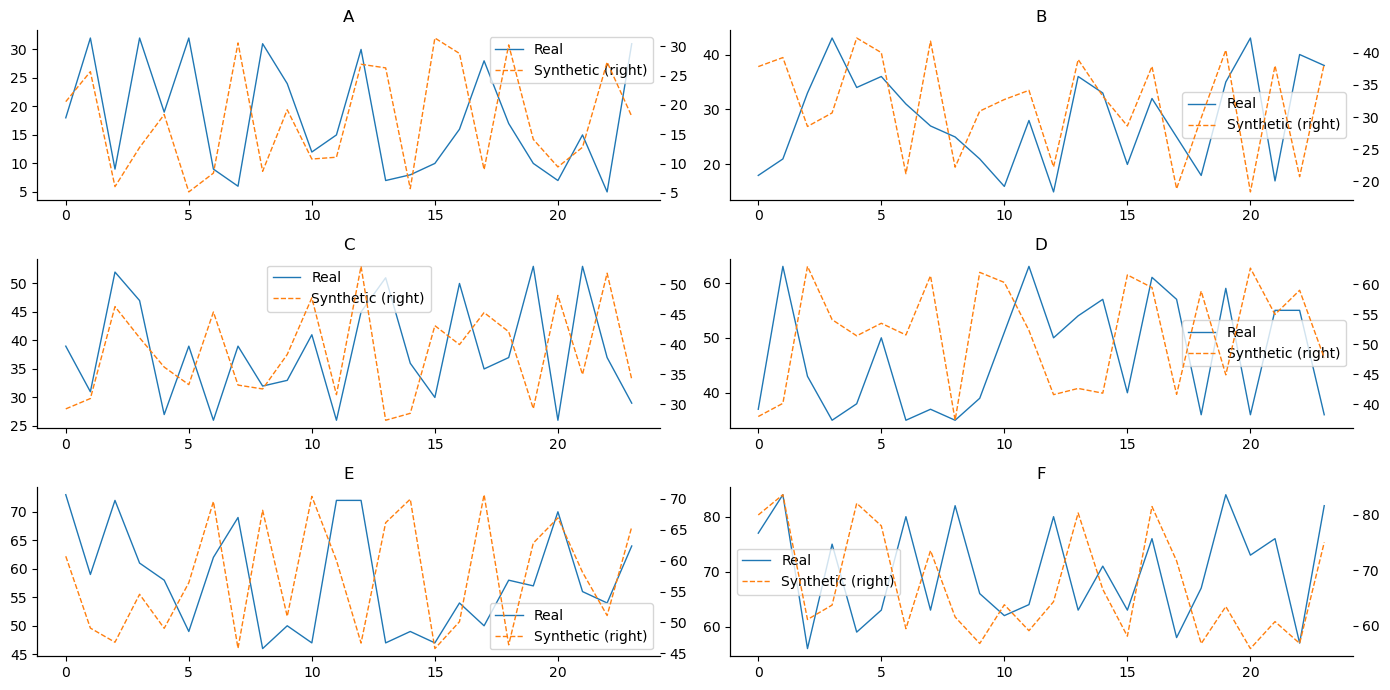

In [113]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()

### Evaluation

In [79]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [81]:
sns.set_style('white')

In [82]:
# seq_len = 24
# n_seq = 6
# experiment = 0

In [83]:
df = pd.read_csv('data/smart_meters_london_2013.csv')
#df.loc[1:2, 1:2]
df = df.iloc[:,1:]


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

real_data = data

In [84]:
n = len(real_data)

In [86]:
np.asarray(real_data).shape # (8736, 24, 4125)

(8736, 24, 4125)

In [88]:
path = Path('2nd_time_gan')
synthetic_data = np.load('2nd_time_gan/experiment_00/generated_data2.npy')
synthetic_data.shape
# (8704, 24, 4125)

(8704, 24, 4125)

In [89]:
real_data = real_data[:synthetic_data.shape[0]]

### Prepare sample

In [90]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [91]:
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [92]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [93]:
real_sample_2d.shape, synthetic_sample_2d.shape

((1031250, 24), (1031250, 24))

# Visualization in 2D

In [96]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pd.concat([pca_real, pca_synthetic]).rename(
    columns={0: '1st Component', 1: '2nd Component'})

In [ ]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

In [ ]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

# Plot Result

In [ ]:

fig, axes = plt.subplots(ncols=1, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

Text(0.5, 1.0, 'PCA Result')

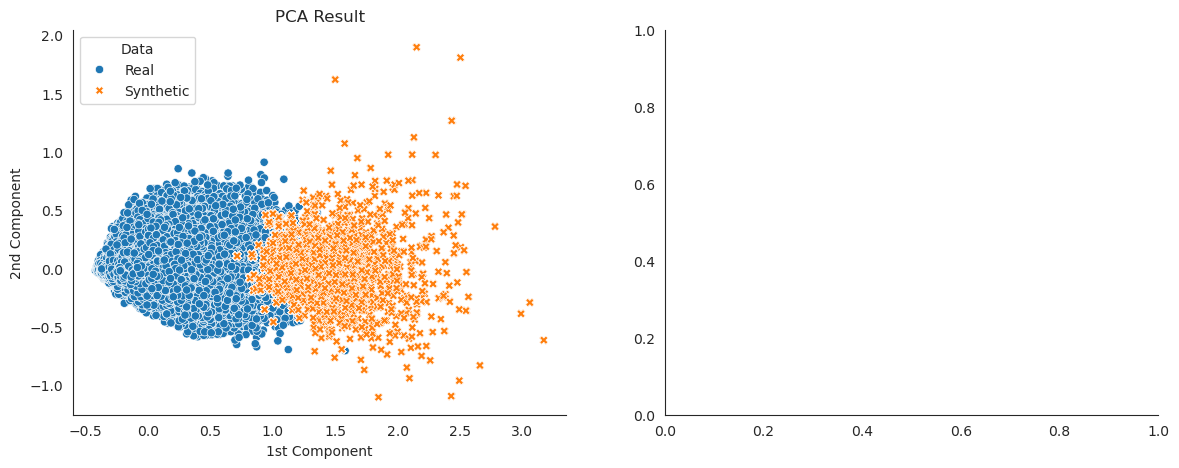

In [98]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')